### **Fetching the dataset**



In [2]:
!curl -O https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
!tar -xf aclImdb_v1.tar.gz
!rm -r aclImdb/train/unsup

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 80.2M  100 80.2M    0     0  5920k      0  0:00:13  0:00:13 --:--:-- 14.5M


### Preprocessing the dataset



In [3]:
import os, pathlib, shutil, random
from tensorflow import keras
import numpy as np

batch_size = 32
base_directory = pathlib.Path("/content/aclImdb")
training_review_dir = base_directory / "train"
validation_review_dir = base_directory / "val"

# Create validation dir and move 10,000 files per class
for category in ("neg", "pos"):
    os.makedirs(validation_review_dir / category, exist_ok=True)

    files = os.listdir(training_review_dir / category)
    random.Random(1496).shuffle(files)

    validation_sample_count = 10000
    validation_files = files[-validation_sample_count:]

    for review_file_name in validation_files:
        shutil.move(
            training_review_dir / category / review_file_name,
            validation_review_dir / category / review_file_name
        )

# Load datasets
train_review_dataset = keras.utils.text_dataset_from_directory(
    "aclImdb/train", batch_size=batch_size
).take(100)

validation_review_dataset = keras.utils.text_dataset_from_directory(
    "/content/aclImdb/val", batch_size=batch_size
)

test_review_dataset = keras.utils.text_dataset_from_directory(
    "aclImdb/test", batch_size=batch_size
)

te_only_train_review_dataset = train_review_dataset.map(lambda x, y: x)



Found 5000 files belonging to 2 classes.
Found 20000 files belonging to 2 classes.
Found 25000 files belonging to 2 classes.


### Transforming text into numerical sequences

### **A sequence model developed using one-hot encoded vectors for the input sequences**

In [4]:
from tensorflow.keras import layers

MAX_SEQUENCE_LENGTH = 150   # Cutoff reviews after 150 words
MAX_VOCAB_SIZE = 10000      # Consider only the top 10,000 words

# Define TextVectorization layer
text_vectorization_layer = layers.TextVectorization(
    max_tokens=MAX_VOCAB_SIZE,
    output_mode="int",
    output_sequence_length=MAX_SEQUENCE_LENGTH,
)

# Extract texts only from train_ds for vectorization adaptation
train_texts_only = train_review_dataset.map(lambda x, y: x)
text_vectorization_layer.adapt(train_texts_only)

# Vectorize the train, validation, and test datasets
vectorized_train_review_dataset = train_review_dataset.map(
    lambda x, y: (text_vectorization_layer(x), y),
    num_parallel_calls=4
)
vectorized_validation_review_dataset = validation_review_dataset.map(
    lambda x, y: (text_vectorization_layer(x), y),
    num_parallel_calls=4
)
int_test_review_dataset = test_review_dataset.map(
    lambda x, y: (text_vectorization_layer(x), y),
    num_parallel_calls=4
)


### **Define the Model with Embedding Layer**

### **We'll define the model with an embedding layer and pretrained word embedding before the Bidirectional layer**.

In [5]:
import tensorflow as tf  # Model with embedding layer

input_layer = keras.Input(shape=(None,), dtype="int64")
embedding_output = layers.Embedding(input_dim=MAX_VOCAB_SIZE, output_dim=256, mask_zero=True)(input_layer)
x = layers.Bidirectional(layers.LSTM(32))(embedding_output)
x = layers.Dropout(0.5)(x)
output_layer = layers.Dense(1, activation="sigmoid")(x)

model = keras.Model(input_layer, output_layer)
model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])

model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, None)           │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding (Embedding)     │ (None, None, 256)      │      2,560,000 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ not_equal (NotEqual)      │ (None, None)           │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional             │ (None, 64)             │         73,984 │ embedding[0][0],       │
│ (Bidirectional)           │                        │                │ not_equal[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 64)             │              0 │ bidirectional[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 1)              │             65 │ dropout[0][0]          │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 2,634,049 (10.05 MB)

 Trainable params: 2,634,049 (10.05 MB)

 Non-trainable params: 0 (0.00 B)

### Developing a fundamental sequencing concept initially

In [6]:
checkpoint_callbacks = [
    keras.callbacks.ModelCheckpoint("one_hot_bidir_lstm.keras",
                                    save_best_only=True)
]
# Ensure this is run before plotting
history = model.fit(vectorized_train_review_dataset, validation_data=vectorized_validation_review_dataset, epochs=15, callbacks=checkpoint_callbacks)


Epoch 1/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 74ms/step - accuracy: 0.5255 - loss: 0.6907 - val_accuracy: 0.6340 - val_loss: 0.6553
Epoch 2/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - accuracy: 0.6903 - loss: 0.6093 - val_accuracy: 0.7697 - val_loss: 0.4900
Epoch 3/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 120ms/step - accuracy: 0.7992 - loss: 0.4528 - val_accuracy: 0.7444 - val_loss: 0.5514
Epoch 4/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 8s 76ms/step - accuracy: 0.8455 - loss: 0.3650 - val_accuracy: 0.7724 - val_loss: 0.4868
Epoch 5/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 10s 74ms/step - accuracy: 0.9098 - loss: 0.2467 - val_accuracy: 0.7918 - val_loss: 0.4579
Epoch 6/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 7s 69ms/step - accuracy: 0.9287 - loss: 0.1954 - val_accuracy: 0.8004 - val_loss: 0.4678
Epoch 7/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 120ms/step - accuracy: 0.9588 - loss: 0.1237 - val_accuracy: 0.7657 - val_loss: 0.5735
Epoch 8/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 7s 73ms/step - accuracy: 0.9711 - loss: 0.0871 - 

In [7]:
model = keras.models.load_model('one_hot_bidir_lstm.keras')
print(f"Test acc: {model.evaluate(int_test_review_dataset)[1]:.3f}")

782/782 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.7866 - loss: 0.4686
Test acc: 0.785


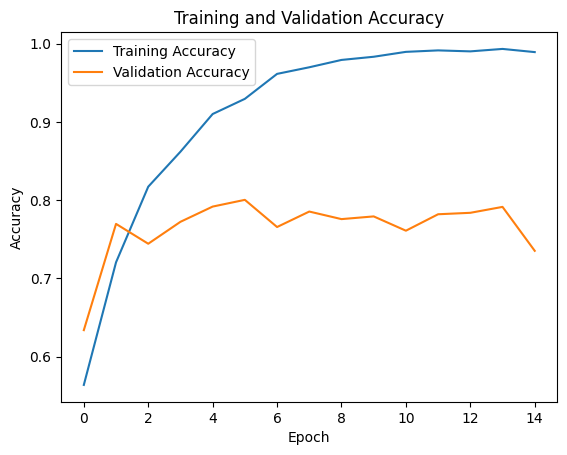

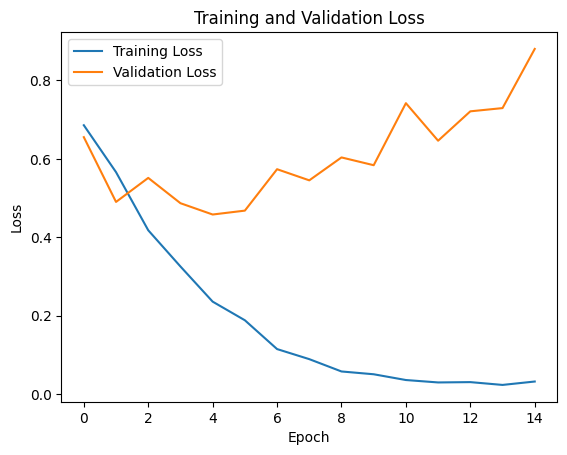

In [8]:

import matplotlib.pyplot as plt

# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()



### Utilizing the Embedding Layer for Word Vectorization

#### Applying the Embedding Mechanism in Practice


In [9]:
em_layer = layers.Embedding(input_dim=MAX_VOCAB_SIZE, output_dim=256)

#### Custom Embedding Layer System Built from Scratch

In [10]:
in1 = keras.Input(shape=(None,), dtype="int64")
em1 = layers.Embedding(input_dim=MAX_VOCAB_SIZE, output_dim=256)(in1)
x = layers.Bidirectional(layers.LSTM(32))(em1)
x = layers.Dropout(0.5)(x)
output_layer1 = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(in1, output_layer1)
model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])
model.summary()



Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, None)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding_2 (Embedding)              │ (None, None, 256)           │       2,560,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ (None, 64)                  │          73,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,634,049 (10.05 MB)

 Trainable params: 2,634,049 (10.05 MB)

 Non-trainable params: 0 (0.00 B)

In [11]:
checkpoint_callbacks1 = [
    keras.callbacks.ModelCheckpoint("embeddings_bidir_gru.keras",  # Change to .keras
                                    save_best_only=True)
]

history1 = model.fit(vectorized_train_review_dataset, validation_data=vectorized_validation_review_dataset, epochs=15, callbacks=checkpoint_callbacks1)

# Load the best model saved by the callback
model = keras.models.load_model("embeddings_bidir_gru.keras")

# Evaluate the model on the test dataset
print(f"Test acc: {model.evaluate(int_test_review_dataset)[1]:.3f}")


Epoch 1/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 9s 71ms/step - accuracy: 0.5161 - loss: 0.6926 - val_accuracy: 0.6202 - val_loss: 0.6529
Epoch 2/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 120ms/step - accuracy: 0.6559 - loss: 0.6325 - val_accuracy: 0.7454 - val_loss: 0.5400
Epoch 3/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 7s 71ms/step - accuracy: 0.7504 - loss: 0.5311 - val_accuracy: 0.7587 - val_loss: 0.5031
Epoch 4/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 10s 68ms/step - accuracy: 0.8290 - loss: 0.4124 - val_accuracy: 0.7614 - val_loss: 0.5067
Epoch 5/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 7s 68ms/step - accuracy: 0.8740 - loss: 0.3333 - val_accuracy: 0.7726 - val_loss: 0.5586
Epoch 6/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 10s 69ms/step - accuracy: 0.8929 - loss: 0.2690 - val_accuracy: 0.7717 - val_loss: 0.5059
Epoch 7/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 10s 70ms/step - accuracy: 0.9362 - loss: 0.1911 - val_accuracy: 0.7686 - val_loss: 0.5079
Epoch 8/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 7s 67ms/step - accuracy: 0.9498 - loss: 0.1332 - val

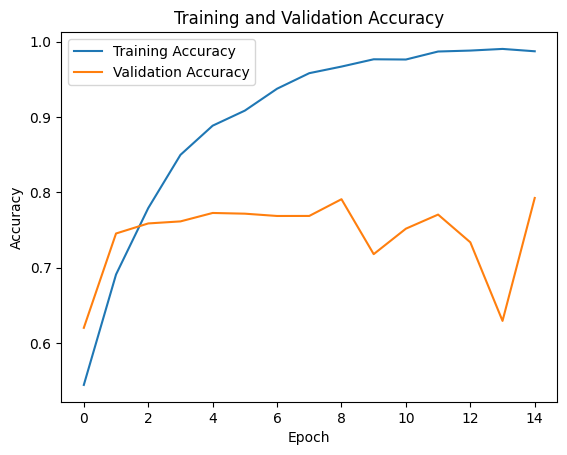

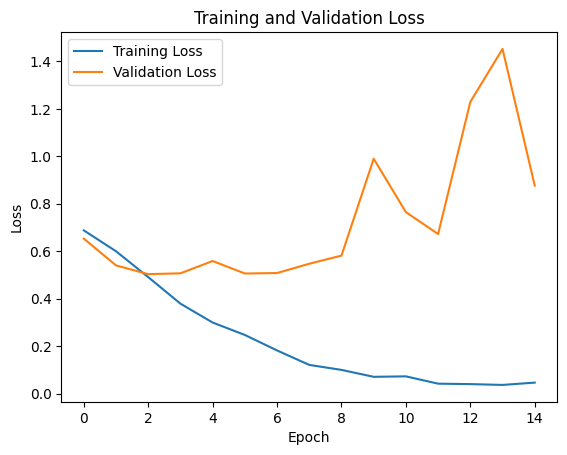

In [12]:
# Plot training and validation accuracy
plt.plot(history1.history['accuracy'], label='Training Accuracy')
plt.plot(history1.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.plot(history1.history['loss'], label='Training Loss')
plt.plot(history1.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Mitigating sequence distortion and handling padding artifacts

### Applying input filtering at the embedding layer


In [13]:
in2 = keras.Input(shape=(None,), dtype="int64")
em2 = layers.Embedding(
    input_dim=MAX_VOCAB_SIZE, output_dim=256, mask_zero=True)(in2)
x = layers.Bidirectional(layers.LSTM(32))(em2)
x = layers.Dropout(0.5)(x)
output_layer2 = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(in2, output_layer2)
model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, None)           │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_3 (Embedding)   │ (None, None, 256)      │      2,560,000 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ not_equal_2 (NotEqual)    │ (None, None)           │              0 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional_2           │ (None, 64)             │         73,984 │ embedding_3[0][0],     │
│ (Bidirectional)           │                        │                │ not_equal_2[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, 64)             │              0 │ bidirectional_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 1)              │             65 │ dropout_2[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 2,634,049 (10.05 MB)

 Trainable params: 2,634,049 (10.05 MB)

 Non-trainable params: 0 (0.00 B)

In [14]:
checkpoint_callbacks2 = [
    keras.callbacks.ModelCheckpoint("embeddings_bidir_gru_with_masking.keras",
                                    save_best_only=True)
]
history2=model.fit(vectorized_train_review_dataset, validation_data= vectorized_validation_review_dataset, epochs=15, callbacks=checkpoint_callbacks2)


Epoch 1/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 10s 78ms/step - accuracy: 0.5184 - loss: 0.6891 - val_accuracy: 0.6780 - val_loss: 0.5944
Epoch 2/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - accuracy: 0.6854 - loss: 0.5876 - val_accuracy: 0.7757 - val_loss: 0.4768
Epoch 3/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - accuracy: 0.8058 - loss: 0.4424 - val_accuracy: 0.7933 - val_loss: 0.4445
Epoch 4/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 14s 67ms/step - accuracy: 0.8692 - loss: 0.3290 - val_accuracy: 0.7930 - val_loss: 0.4410
Epoch 5/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 7s 73ms/step - accuracy: 0.9017 - loss: 0.2625 - val_accuracy: 0.7163 - val_loss: 0.6750
Epoch 6/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 7s 68ms/step - accuracy: 0.9189 - loss: 0.2076 - val_accuracy: 0.7965 - val_loss: 0.5155
Epoch 7/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 7s 72ms/step - accuracy: 0.9421 - loss: 0.1537 - val_accuracy: 0.7911 - val_loss: 0.4975
Epoch 8/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 15s 120ms/step - accuracy: 0.9675 - loss: 0.0977 - 

In [15]:

model = keras.models.load_model("embeddings_bidir_gru_with_masking.keras")
print(f"Test acc: {model.evaluate(int_test_review_dataset)[1]:.3f}")

782/782 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.7920 - loss: 0.4485
Test acc: 0.792


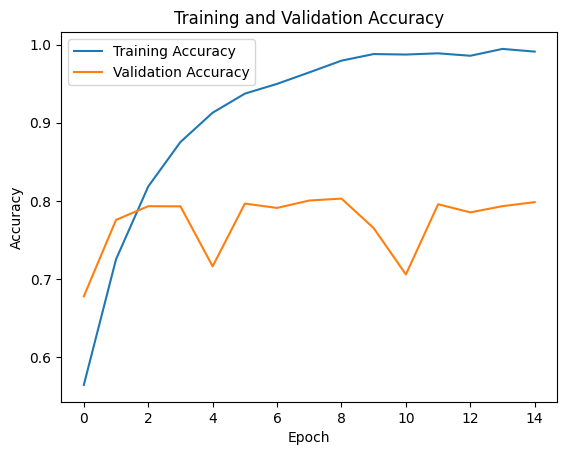

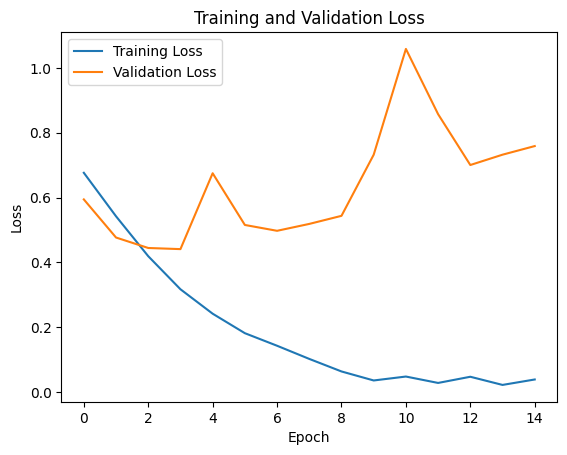

In [16]:
# Plot training and validation accuracy
plt.plot(history2.history['accuracy'], label='Training Accuracy')
plt.plot(history2.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.plot(history2.history['loss'], label='Training Loss')
plt.plot(history2.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Utilizing Pretrained Word Embeddings

In [17]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip -q glove.6B.zip

--2025-04-08 04:47:43--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2025-04-08 04:47:43--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2025-04-08 04:47:44--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

#### Interpreting a Single Word Using Word Embeddings

In [18]:
import numpy as np
GLOVE_FILE_PATH = "glove.6B.100d.txt"

glove_embeddings = {}
with open(GLOVE_FILE_PATH) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        glove_embeddings[word] = coefs

print(f"Found {len(glove_embeddings)} word vectors.")

Found 400000 word vectors.


#### Configuring the Embedding Matrix Using GloVe Vectors from the Official Source

In [19]:
em_dim = 100

vocab = text_vectorization_layer.get_vocabulary()
word_to_index = dict(zip(vocab, range(len(vocab))))

embedding_matrix = np.zeros((MAX_VOCAB_SIZE, em_dim))
for word, i in word_to_index.items():
    if i < MAX_VOCAB_SIZE:
        em_vector = glove_embeddings.get(word)
    if em_vector is not None:
        embedding_matrix[i] = em_vector

In [20]:
em_layer = layers.Embedding(
    MAX_VOCAB_SIZE,
    em_dim,
    embeddings_initializer=keras.initializers.Constant(embedding_matrix),
    trainable=False,
    mask_zero=True,
)

### Model Architecture with a Trainable Embedding Layer



In [21]:
in4 = keras.Input(shape=(None,), dtype="int64")
em4 = em_layer(in4)
x = layers.Bidirectional(layers.LSTM(32))(em4)
x = layers.Dropout(0.5)(x)
output_layer4 = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(in4, output_layer4)
model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])
model.summary()


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3             │ (None, None)           │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_4 (Embedding)   │ (None, None, 100)      │      1,000,000 │ input_layer_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ not_equal_4 (NotEqual)    │ (None, None)           │              0 │ input_layer_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional_3           │ (None, 64)             │         34,048 │ embedding_4[0][0],     │
│ (Bidirectional)           │                        │                │ not_equal_4[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_3 (Dropout)       │ (None, 64)             │              0 │ bidirectional_3[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_3 (Dense)           │ (None, 1)              │             65 │ dropout_3[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 1,034,113 (3.94 MB)

 Trainable params: 34,113 (133.25 KB)

 Non-trainable params: 1,000,000 (3.81 MB)

In [22]:
checkpoint_callbacks4 = [
    keras.callbacks.ModelCheckpoint("glove_embeddings_sequence_model.keras",
                                    save_best_only=True)
]

history4=model.fit(vectorized_train_review_dataset, validation_data= vectorized_validation_review_dataset, epochs=15, callbacks=checkpoint_callbacks4)
model = keras.models.load_model("glove_embeddings_sequence_model.keras")
print(f"Test Accuracy: {model.evaluate(int_test_review_dataset)[1]:.3f}")

Epoch 1/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 97ms/step - accuracy: 0.5544 - loss: 0.6904 - val_accuracy: 0.6406 - val_loss: 0.6371
Epoch 2/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 10s 99ms/step - accuracy: 0.6395 - loss: 0.6357 - val_accuracy: 0.6894 - val_loss: 0.5905
Epoch 3/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 10s 95ms/step - accuracy: 0.6939 - loss: 0.5944 - val_accuracy: 0.7097 - val_loss: 0.5676
Epoch 4/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 9s 85ms/step - accuracy: 0.7107 - loss: 0.5639 - val_accuracy: 0.7045 - val_loss: 0.5587
Epoch 5/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 100ms/step - accuracy: 0.7332 - loss: 0.5440 - val_accuracy: 0.7324 - val_loss: 0.5367
Epoch 6/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 10s 96ms/step - accuracy: 0.7484 - loss: 0.5209 - val_accuracy: 0.7580 - val_loss: 0.4988
Epoch 7/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 9s 84ms/step - accuracy: 0.7548 - loss: 0.5115 - val_accuracy: 0.7725 - val_loss: 0.4777
Epoch 8/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 8s 66ms/step - accuracy: 0.7620 - loss: 0.4940 - va

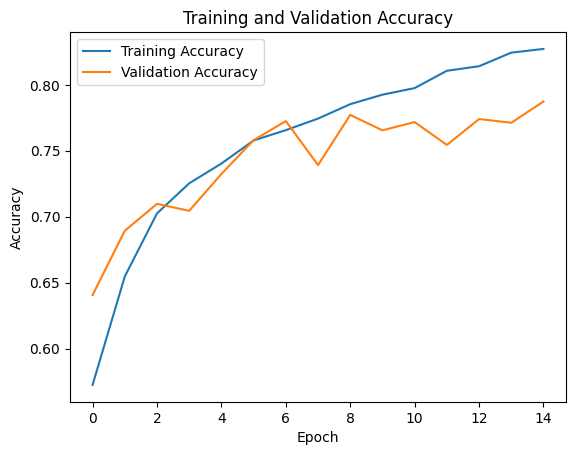

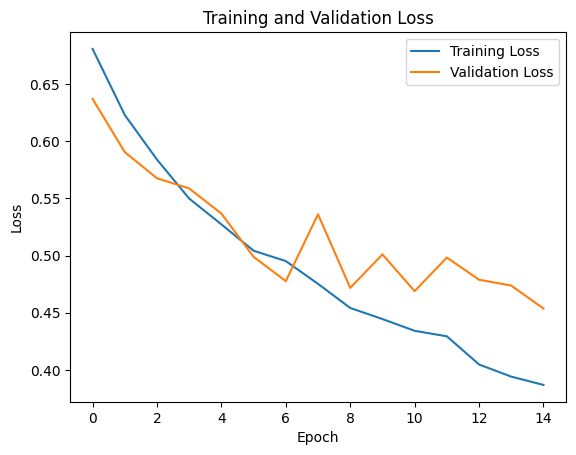

In [23]:
# Plot training and validation accuracy
plt.plot(history4.history['accuracy'], label='Training Accuracy')
plt.plot(history4.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.plot(history4.history['loss'], label='Training Loss')
plt.plot(history4.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

Found 5000 files belonging to 2 classes.
Epoch 1/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 15s 128ms/step - accuracy: 0.5019 - loss: 0.6926 - val_accuracy: 0.5497 - val_loss: 0.6878
Epoch 2/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 8s 76ms/step - accuracy: 0.6361 - loss: 0.6451 - val_accuracy: 0.7298 - val_loss: 0.5632
Epoch 3/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 10s 69ms/step - accuracy: 0.7866 - loss: 0.4846 - val_accuracy: 0.7438 - val_loss: 0.5484
Epoch 4/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 9s 61ms/step - accuracy: 0.8280 - loss: 0.4297 - val_accuracy: 0.7894 - val_loss: 0.4721
Epoch 5/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 8s 75ms/step - accuracy: 0.8852 - loss: 0.3137 - val_accuracy: 0.7724 - val_loss: 0.5096
Epoch 6/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 61ms/step - accuracy: 0.8972 - loss: 0.2675 - val_accuracy: 0.7976 - val_loss: 0.4634
Epoch 7/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 118ms/step - accuracy: 0.9381 - loss: 0.1916 - val_accuracy: 0.7416 - val_loss: 0.6361
Epoch 8/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 15s 61ms/st

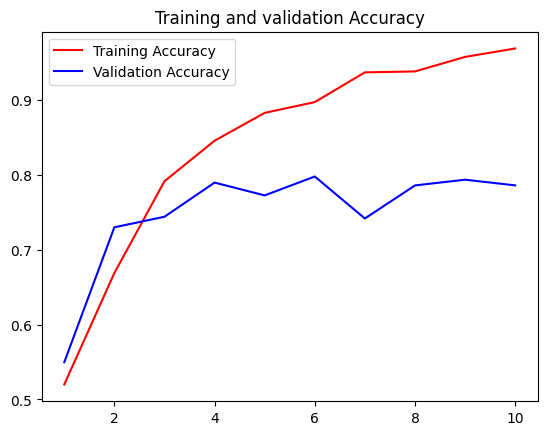

Epoch 1/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 11s 99ms/step - accuracy: 0.5199 - loss: 0.7038 - val_accuracy: 0.6324 - val_loss: 0.6501
Epoch 2/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 9s 91ms/step - accuracy: 0.6398 - loss: 0.6373 - val_accuracy: 0.6854 - val_loss: 0.5943
Epoch 3/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 9s 82ms/step - accuracy: 0.7006 - loss: 0.5837 - val_accuracy: 0.7169 - val_loss: 0.5586
Epoch 4/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 9s 94ms/step - accuracy: 0.7260 - loss: 0.5515 - val_accuracy: 0.7484 - val_loss: 0.5191
Epoch 5/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 9s 95ms/step - accuracy: 0.7374 - loss: 0.5197 - val_accuracy: 0.7589 - val_loss: 0.5030
Epoch 6/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 63ms/step - accuracy: 0.7695 - loss: 0.4936 - val_accuracy: 0.7500 - val_loss: 0.5095
Epoch 7/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 92ms/step - accuracy: 0.7729 - loss: 0.4756 - val_accuracy: 0.7710 - val_loss: 0.4854
Epoch 8/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 8s 76ms/step - accuracy: 0.7937 - loss: 0.4646 - val_ac

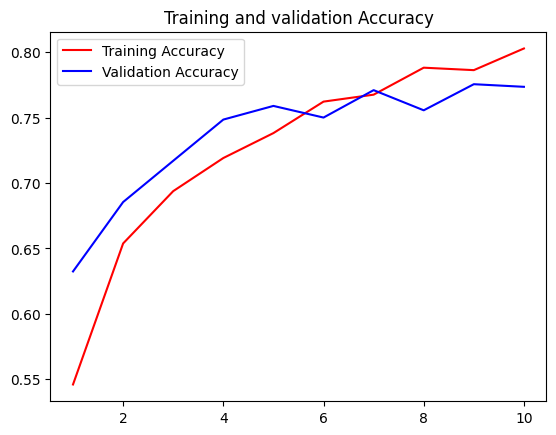

Training samples: 100
Embedding layer test accuracy: 0.788
Pretrained embeddings test accuracy: 0.767
--------------------------------------------------
Found 5000 files belonging to 2 classes.
Epoch 1/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 10s 46ms/step - accuracy: 0.5328 - loss: 0.6903 - val_accuracy: 0.6414 - val_loss: 0.6422
Epoch 2/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 8s 53ms/step - accuracy: 0.7070 - loss: 0.5813 - val_accuracy: 0.7550 - val_loss: 0.5376
Epoch 3/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 10s 50ms/step - accuracy: 0.7982 - loss: 0.4625 - val_accuracy: 0.7970 - val_loss: 0.4503
Epoch 4/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 10s 48ms/step - accuracy: 0.8581 - loss: 0.3513 - val_accuracy: 0.7635 - val_loss: 0.4840
Epoch 5/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 11s 50ms/step - accuracy: 0.8914 - loss: 0.2963 - val_accuracy: 0.8047 - val_loss: 0.5083
Epoch 6/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 8s 53ms/step - accuracy: 0.9097 - loss: 0.2462 - val_accuracy: 0.7851 - val_loss: 0.5629
Epoch 7/10
157/157 ━━━━━━━━━

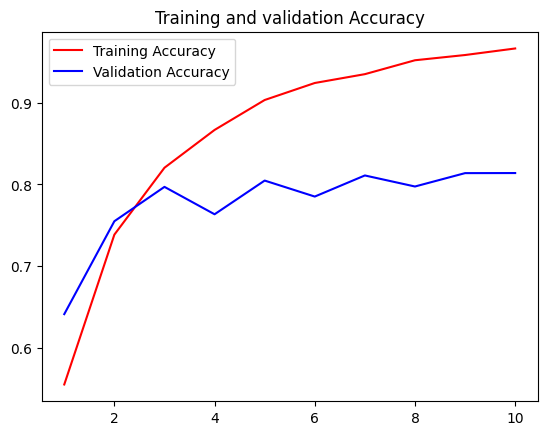

Epoch 1/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 13s 69ms/step - accuracy: 0.5373 - loss: 0.6944 - val_accuracy: 0.6740 - val_loss: 0.6122
Epoch 2/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 9s 56ms/step - accuracy: 0.6736 - loss: 0.6163 - val_accuracy: 0.5854 - val_loss: 0.7464
Epoch 3/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 12s 65ms/step - accuracy: 0.7088 - loss: 0.5733 - val_accuracy: 0.7563 - val_loss: 0.5084
Epoch 4/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 8s 48ms/step - accuracy: 0.7489 - loss: 0.5318 - val_accuracy: 0.6974 - val_loss: 0.5606
Epoch 5/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 9s 54ms/step - accuracy: 0.7552 - loss: 0.5121 - val_accuracy: 0.7283 - val_loss: 0.5491
Epoch 6/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 9s 59ms/step - accuracy: 0.7658 - loss: 0.4876 - val_accuracy: 0.7824 - val_loss: 0.4674
Epoch 7/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 10s 59ms/step - accuracy: 0.7868 - loss: 0.4690 - val_accuracy: 0.7816 - val_loss: 0.4626
Epoch 8/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 11s 66ms/step - accuracy: 0.7960 - loss: 0.4455 - val_

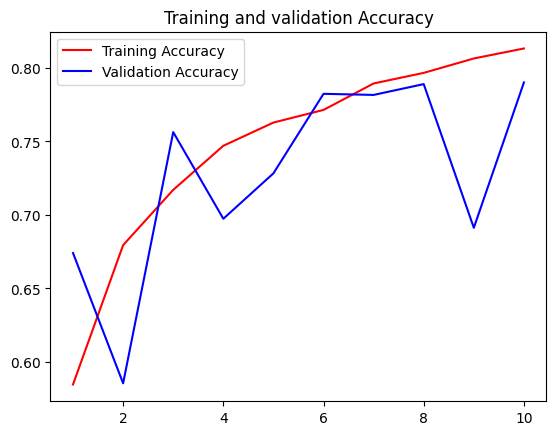

Training samples: 500
Embedding layer test accuracy: 0.794
Pretrained embeddings test accuracy: 0.784
--------------------------------------------------
Found 5000 files belonging to 2 classes.
Epoch 1/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 12s 65ms/step - accuracy: 0.5199 - loss: 0.6910 - val_accuracy: 0.5943 - val_loss: 0.6788
Epoch 2/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.7091 - loss: 0.5752 - val_accuracy: 0.7352 - val_loss: 0.5409
Epoch 3/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 11s 48ms/step - accuracy: 0.8170 - loss: 0.4380 - val_accuracy: 0.8027 - val_loss: 0.4511
Epoch 4/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 11s 53ms/step - accuracy: 0.8731 - loss: 0.3388 - val_accuracy: 0.6884 - val_loss: 0.7042
Epoch 5/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 8s 53ms/step - accuracy: 0.8872 - loss: 0.2986 - val_accuracy: 0.8084 - val_loss: 0.5780
Epoch 6/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 7s 43ms/step - accuracy: 0.9192 - loss: 0.2333 - val_accuracy: 0.8030 - val_loss: 0.6219
Epoch 7/10
157/157 ━━━━━━━━━━

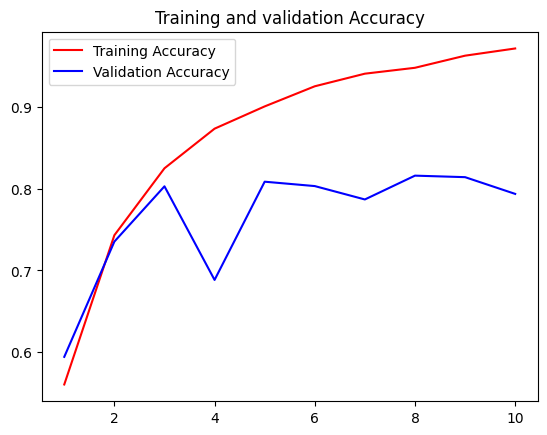

Epoch 1/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 17s 94ms/step - accuracy: 0.5497 - loss: 0.6929 - val_accuracy: 0.6837 - val_loss: 0.5987
Epoch 2/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 9s 55ms/step - accuracy: 0.6888 - loss: 0.5951 - val_accuracy: 0.6357 - val_loss: 0.6660
Epoch 3/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 10s 65ms/step - accuracy: 0.7158 - loss: 0.5609 - val_accuracy: 0.7535 - val_loss: 0.5147
Epoch 4/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 7s 46ms/step - accuracy: 0.7398 - loss: 0.5328 - val_accuracy: 0.7357 - val_loss: 0.5234
Epoch 5/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 13s 64ms/step - accuracy: 0.7508 - loss: 0.5019 - val_accuracy: 0.7515 - val_loss: 0.5042
Epoch 6/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 11s 67ms/step - accuracy: 0.7910 - loss: 0.4663 - val_accuracy: 0.7728 - val_loss: 0.4792
Epoch 7/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 10s 66ms/step - accuracy: 0.7787 - loss: 0.4637 - val_accuracy: 0.7883 - val_loss: 0.4501
Epoch 8/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 19s 56ms/step - accuracy: 0.8030 - loss: 0.4355 - va

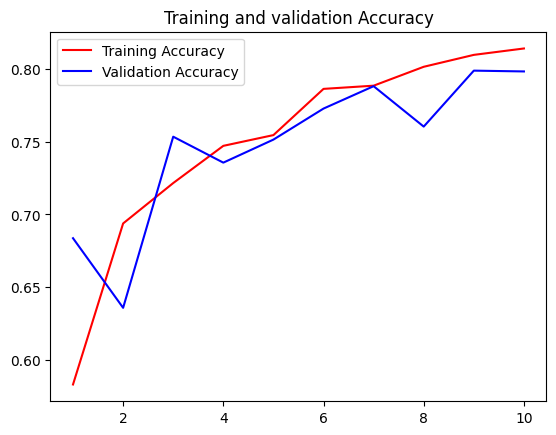

Training samples: 1000
Embedding layer test accuracy: 0.797
Pretrained embeddings test accuracy: 0.793
--------------------------------------------------
Found 5000 files belonging to 2 classes.
Epoch 1/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 12s 62ms/step - accuracy: 0.5156 - loss: 0.6914 - val_accuracy: 0.6866 - val_loss: 0.6062
Epoch 2/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 13s 81ms/step - accuracy: 0.6967 - loss: 0.5928 - val_accuracy: 0.7373 - val_loss: 0.5307
Epoch 3/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 8s 49ms/step - accuracy: 0.8146 - loss: 0.4397 - val_accuracy: 0.8043 - val_loss: 0.4779
Epoch 4/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.8571 - loss: 0.3652 - val_accuracy: 0.8134 - val_loss: 0.4229
Epoch 5/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 8s 53ms/step - accuracy: 0.8961 - loss: 0.2752 - val_accuracy: 0.7748 - val_loss: 0.4919
Epoch 6/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 10s 51ms/step - accuracy: 0.9280 - loss: 0.2237 - val_accuracy: 0.7884 - val_loss: 0.5202
Epoch 7/10
157/157 ━━━━━━━━

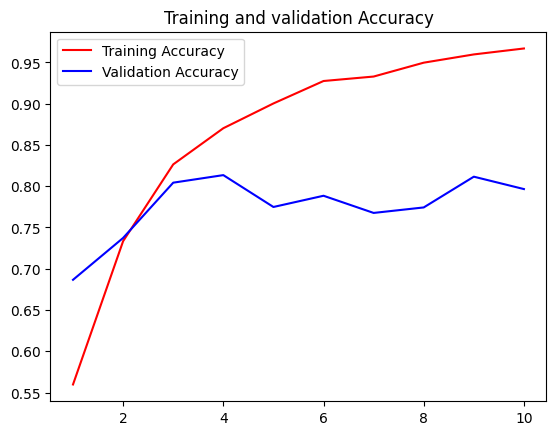

Epoch 1/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 16s 93ms/step - accuracy: 0.5330 - loss: 0.6987 - val_accuracy: 0.6162 - val_loss: 0.6513
Epoch 2/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 15s 59ms/step - accuracy: 0.6561 - loss: 0.6204 - val_accuracy: 0.6255 - val_loss: 0.6379
Epoch 3/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 11s 63ms/step - accuracy: 0.7087 - loss: 0.5789 - val_accuracy: 0.7256 - val_loss: 0.5413
Epoch 4/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 14s 84ms/step - accuracy: 0.7353 - loss: 0.5456 - val_accuracy: 0.5813 - val_loss: 0.7969
Epoch 5/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 17s 63ms/step - accuracy: 0.7602 - loss: 0.5116 - val_accuracy: 0.7785 - val_loss: 0.4712
Epoch 6/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 8s 50ms/step - accuracy: 0.7705 - loss: 0.4844 - val_accuracy: 0.7829 - val_loss: 0.4757
Epoch 7/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 11s 54ms/step - accuracy: 0.7776 - loss: 0.4677 - val_accuracy: 0.7485 - val_loss: 0.5085
Epoch 8/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 13s 80ms/step - accuracy: 0.7925 - loss: 0.4405 - v

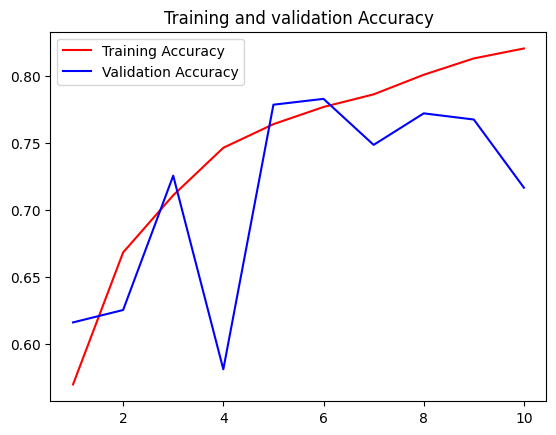

Training samples: 5000
Embedding layer test accuracy: 0.804
Pretrained embeddings test accuracy: 0.771
--------------------------------------------------
Found 5000 files belonging to 2 classes.
Epoch 1/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 9s 46ms/step - accuracy: 0.5281 - loss: 0.6915 - val_accuracy: 0.6535 - val_loss: 0.6374
Epoch 2/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.7020 - loss: 0.5933 - val_accuracy: 0.7395 - val_loss: 0.5278
Epoch 3/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 12s 54ms/step - accuracy: 0.8195 - loss: 0.4386 - val_accuracy: 0.7832 - val_loss: 0.4902
Epoch 4/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 8s 49ms/step - accuracy: 0.8662 - loss: 0.3502 - val_accuracy: 0.8124 - val_loss: 0.4792
Epoch 5/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 8s 48ms/step - accuracy: 0.8915 - loss: 0.2969 - val_accuracy: 0.7703 - val_loss: 0.6104
Epoch 6/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 11s 54ms/step - accuracy: 0.9136 - loss: 0.2374 - val_accuracy: 0.7955 - val_loss: 0.5324
Epoch 7/10
157/157 ━━━━━━━━━

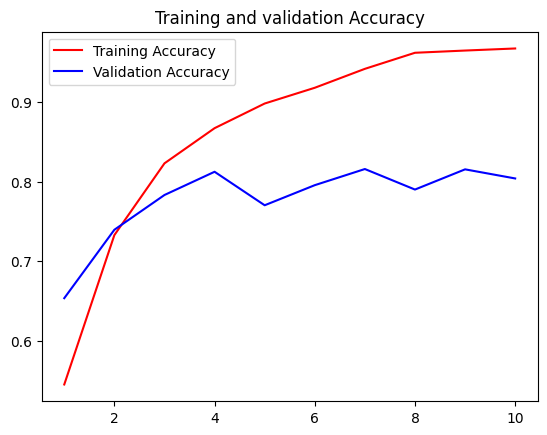

Epoch 1/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 13s 70ms/step - accuracy: 0.5412 - loss: 0.6961 - val_accuracy: 0.5849 - val_loss: 0.6716
Epoch 2/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 14s 92ms/step - accuracy: 0.6611 - loss: 0.6186 - val_accuracy: 0.6130 - val_loss: 0.6521
Epoch 3/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 10s 65ms/step - accuracy: 0.7269 - loss: 0.5582 - val_accuracy: 0.6804 - val_loss: 0.5860
Epoch 4/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 11s 68ms/step - accuracy: 0.7514 - loss: 0.5153 - val_accuracy: 0.6974 - val_loss: 0.5654
Epoch 5/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 9s 59ms/step - accuracy: 0.7779 - loss: 0.4827 - val_accuracy: 0.7665 - val_loss: 0.5007
Epoch 6/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 8s 52ms/step - accuracy: 0.7883 - loss: 0.4582 - val_accuracy: 0.7390 - val_loss: 0.5165
Epoch 7/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 13s 81ms/step - accuracy: 0.8089 - loss: 0.4333 - val_accuracy: 0.7129 - val_loss: 0.5659
Epoch 8/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 17s 59ms/step - accuracy: 0.8110 - loss: 0.4189 - va

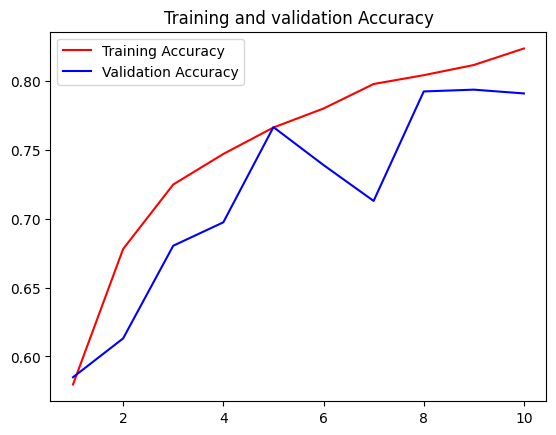

Training samples: 10000
Embedding layer test accuracy: 0.806
Pretrained embeddings test accuracy: 0.793
--------------------------------------------------
Found 5000 files belonging to 2 classes.
Epoch 1/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 15s 84ms/step - accuracy: 0.5341 - loss: 0.6895 - val_accuracy: 0.6406 - val_loss: 0.6324
Epoch 2/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 15s 47ms/step - accuracy: 0.7276 - loss: 0.5641 - val_accuracy: 0.7681 - val_loss: 0.5007
Epoch 3/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 13s 81ms/step - accuracy: 0.8116 - loss: 0.4411 - val_accuracy: 0.7873 - val_loss: 0.4599
Epoch 4/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 15s 49ms/step - accuracy: 0.8751 - loss: 0.3274 - val_accuracy: 0.6464 - val_loss: 0.8842
Epoch 5/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 8s 53ms/step - accuracy: 0.9027 - loss: 0.2705 - val_accuracy: 0.8029 - val_loss: 0.5219
Epoch 6/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 8s 48ms/step - accuracy: 0.9110 - loss: 0.2430 - val_accuracy: 0.7551 - val_loss: 0.5486
Epoch 7/10
157/157 ━━━━━━━

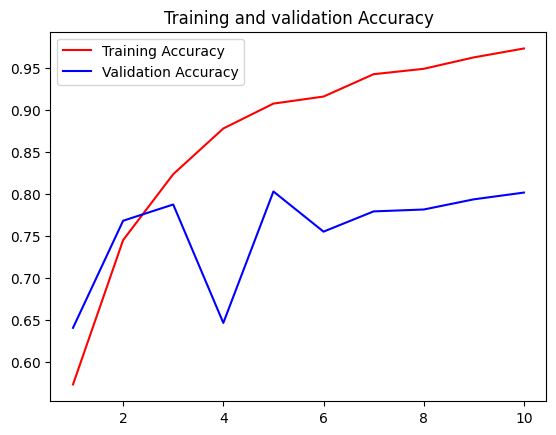

Epoch 1/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 12s 68ms/step - accuracy: 0.5311 - loss: 0.7003 - val_accuracy: 0.5710 - val_loss: 0.6789
Epoch 2/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 20s 65ms/step - accuracy: 0.6663 - loss: 0.6231 - val_accuracy: 0.6453 - val_loss: 0.6462
Epoch 3/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 8s 50ms/step - accuracy: 0.7282 - loss: 0.5529 - val_accuracy: 0.6292 - val_loss: 0.6999
Epoch 4/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 18s 97ms/step - accuracy: 0.7377 - loss: 0.5320 - val_accuracy: 0.6769 - val_loss: 0.6006
Epoch 5/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 16s 67ms/step - accuracy: 0.7667 - loss: 0.4987 - val_accuracy: 0.7757 - val_loss: 0.4712
Epoch 6/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 19s 55ms/step - accuracy: 0.7888 - loss: 0.4640 - val_accuracy: 0.7556 - val_loss: 0.4949
Epoch 7/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 16s 92ms/step - accuracy: 0.7983 - loss: 0.4435 - val_accuracy: 0.7908 - val_loss: 0.4540
Epoch 8/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 11s 69ms/step - accuracy: 0.8048 - loss: 0.4311 - v

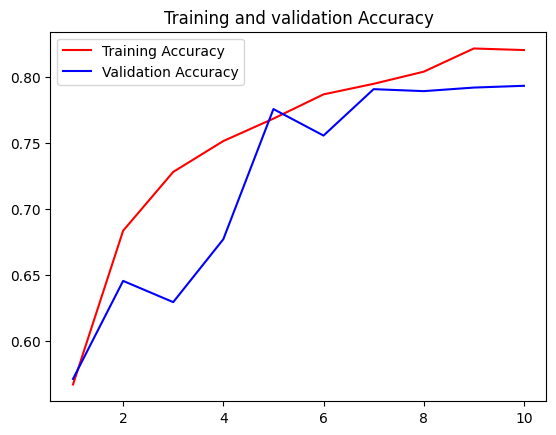

Training samples: 20000
Embedding layer test accuracy: 0.776
Pretrained embeddings test accuracy: 0.787
--------------------------------------------------


In [24]:
train_sample_sizes = [100, 500, 1000, 5000, 10000, 20000]
for train_size in train_sample_sizes:
    train_review_dataset = keras.utils.text_dataset_from_directory(
        "aclImdb/train", batch_size=batch_size
    ).take(train_size)

    int_train_review_dataset = train_review_dataset.map(
        lambda x, y: (text_vectorization_layer(x), y),
        num_parallel_calls=4
    )
    int_validation_review_dataset = validation_review_dataset.map(
        lambda x, y: (text_vectorization_layer(x), y),
        num_parallel_calls=4
    )
    int_test_review_dataset = test_review_dataset.map(
        lambda x, y: (text_vectorization_layer(x), y),
        num_parallel_calls=4
    )

    # Train and evaluate the model with the embedding layer
    embedding_layer = layers.Embedding(MAX_VOCAB_SIZE, em_dim)

    inputs = keras.Input(shape=(None,), dtype="int64")
    embedded = embedding_layer(inputs)
    x = layers.Bidirectional(layers.LSTM(32))(embedded)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)
    model = keras.Model(inputs, outputs)
    model.compile(optimizer="rmsprop",
                  loss="binary_crossentropy",
                  metrics=["accuracy"])

    callbacks = [
        keras.callbacks.ModelCheckpoint("embeddings_model.keras", save_best_only=True)
    ]
    history = model.fit(int_train_review_dataset, validation_data=int_validation_review_dataset, epochs=10, callbacks=callbacks)
    model = keras.models.load_model("embeddings_model.keras")
    embedding_layer_test_acc = model.evaluate(int_test_review_dataset)[1]

    loss = history.history["accuracy"]
    val_loss = history.history["val_accuracy"]
    epochs = range(1, len(loss) + 1)
    plt.figure()
    plt.plot(epochs, loss, "r", label="Training Accuracy")
    plt.plot(epochs, val_loss, "b", label="Validation Accuracy")
    plt.title("Training and validation Accuracy")
    plt.legend()
    plt.show()

    # Train and evaluate the model with the pretrained word embeddings
    embedding_layer = layers.Embedding(
        MAX_VOCAB_SIZE,
        em_dim,
        embeddings_initializer=keras.initializers.Constant(embedding_matrix),
        trainable=False,
        mask_zero=True,
    )

    inputs = keras.Input(shape=(None,), dtype="int64")
    embedded = embedding_layer(inputs)
    x = layers.Bidirectional(layers.LSTM(32))(embedded)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)
    model = keras.Model(inputs, outputs)
    model.compile(optimizer="rmsprop",
                  loss="binary_crossentropy",
                  metrics=["accuracy"])

    callbacks = [
        keras.callbacks.ModelCheckpoint("pretrained_embeddings_model.keras", save_best_only=True)
    ]
    history = model.fit(int_train_review_dataset, validation_data=int_validation_review_dataset, epochs=10, callbacks=callbacks)
    model = keras.models.load_model("pretrained_embeddings_model.keras")
    pretrained_embeddings_test_acc = model.evaluate(int_test_review_dataset)[1]

    loss = history.history["accuracy"]
    val_loss = history.history["val_accuracy"]
    epochs = range(1, len(loss) + 1)
    plt.figure()
    plt.plot(epochs, loss, "r", label="Training Accuracy")
    plt.plot(epochs, val_loss, "b", label="Validation Accuracy")
    plt.title("Training and validation Accuracy")
    plt.legend()
    plt.show()

    # Compare the performance and store the results
    print(f"Training samples: {train_size}")
    print(f"Embedding layer test accuracy: {embedding_layer_test_acc:.3f}")
    print(f"Pretrained embeddings test accuracy: {pretrained_embeddings_test_acc:.3f}")
    print("-" * 50)


